In [8]:
import nexradaws
import six
import shutil 
from datetime import datetime 
import os
import tempfile

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

import netCDF4

import xarray as xr

import boto3
# from tint import Cell_tracks, animate
# from tint.visualization import embed_mp4_as_gif

import pyart

import cartopy 
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature


templocation = tempfile.mkdtemp()
%config InlineBackend.figure_format='retina'

In [2]:
conn = nexradaws.NexradAwsInterface()

radar_id = 'KLOT'
start = datetime(2020,2,5,21,0) #Year, month, day, hour, minute
end = datetime(2020,2,5,21,15)

scans = conn.get_avail_scans_in_range(start, end, radar_id)
print("There are {} scans available between {} and {}\n".format(len(scans), start, end))


templocation = tempfile.mkdtemp()

results = conn.download(scans, templocation)

files = os.listdir(templocation)
files.sort()
interesting_files = []
for fn in files:
    if radar_id in fn:
        interesting_files.append(templocation + '/' + fn)

interesting_files = [x for x in interesting_files if not 'MDM' in x] #removes mdm files

interesting_files

There are 1 scans available between 2020-02-05 21:00:00 and 2020-02-05 21:15:00

Downloaded KLOT20200205_210603_V06
1 out of 1 files downloaded...0 errors


['/var/folders/8v/2vrvzpzx2ml8xgfscky7r5dw0000gn/T/tmpsbgw4_9e/KLOT20200205_210603_V06']

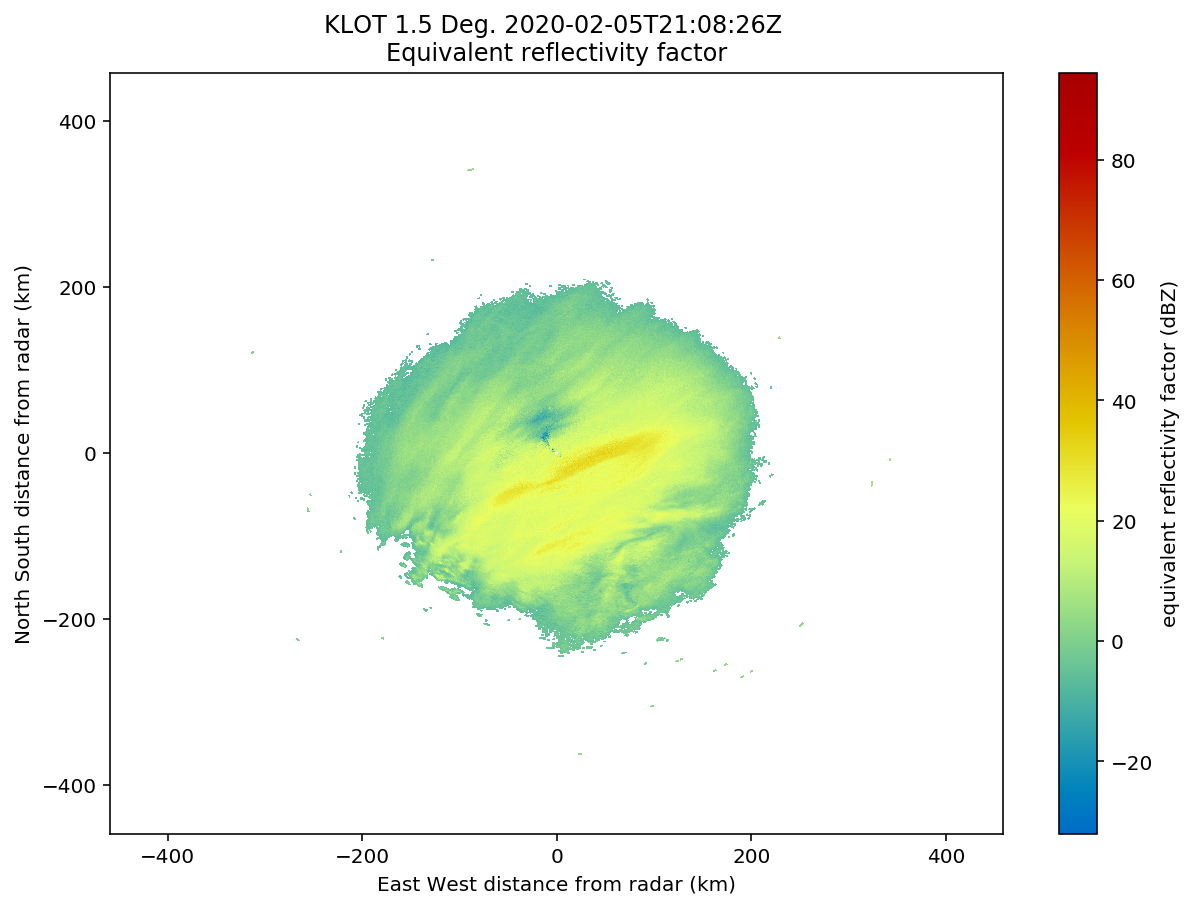

In [3]:
fig = plt.figure(figsize=(10, 7))

file_name_sample = interesting_files[0]
radar = pyart.io.read(file_name_sample)

radar.fixed_angle['data']
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi('reflectivity', sweep = 2)
plt.show()

In [4]:
grids = pyart.map.grid_from_radars((radar),(34,401,401),
                                  ((500.,17500.),(-400000.,400000.),(-400000.,400000.)),
                                  #fields=['reflectivity', 'velocity', 'differential_reflectivity', 'cross_correlation_ratio','differential_phase'],
                                  fields=['reflectivity', 'velocity'],
                                  refl_field='reflectivity')

/Users/troyzaremba/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pyart/map/gates_to_grid.py:162: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


In [9]:
#Creates an empty xarray dataset to store all the fields with latitude,longitude, time and height.
long,lat = grids.get_point_longitude_latitude()
height = grids.point_z['data'][:,0,0]
time = np.array([ netCDF4.num2date(grids.time['data'][0], grids.time['units'])])
ds = xr.Dataset()

for this_field in list(grids.fields.keys()):
    this_data = grids.fields[this_field]['data']
    my_data = xr.DataArray(np.ma.expand_dims(this_data,0),
                          dims=('time','z','y','x'),
                          coords={'time':(['time'],time),
                                 'z':(['z'],height),
                                 'lat':(['y','x'],lat),
                                 'lon':(['y','x'],long),
                                 'y':(['y'],lat[:,0]),
                                 'x':(['x'],long[0,:])})
    
    for this_meta in list(grids.fields[this_field].keys()):
        if this_meta is not 'data':
            my_data.attrs.update({this_meta:grids.fields[this_field][this_meta]})
            
    ds[this_field] = my_data
    ds.lon.attrs = [('long_name','longitude of grid cell center'),
                   ('units','degrees_east')]
    ds.lat.attrs = [('lat_name','latitude of grid cell center'),
                   ('units','degrees_north')]
    ds.z.attrs['long_name'] = "height above sea level"
    ds.z.attrs['units'] = "m"
    
    ds.z.encoding['_FillValue'] =None
    ds.lat.encoding['_FillValue'] = None
    ds.lon.encoding['_FillValue'] = None

In [10]:
#Plotting parameters
mpl.rcParams['xtick.major.size'] = 14
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 14
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 14
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 14
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.serif'] = ['Helvetica']
mpl.rc('xtick',labelsize=16)    # Formatting the x ticks
mpl.rc('ytick',labelsize=16)

NameError: name 'mpl' is not defined

/Users/troyzaremba/opt/anaconda3/envs/py37/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/Users/troyzaremba/opt/anaconda3/envs/py37/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_1_states_provinces_lines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


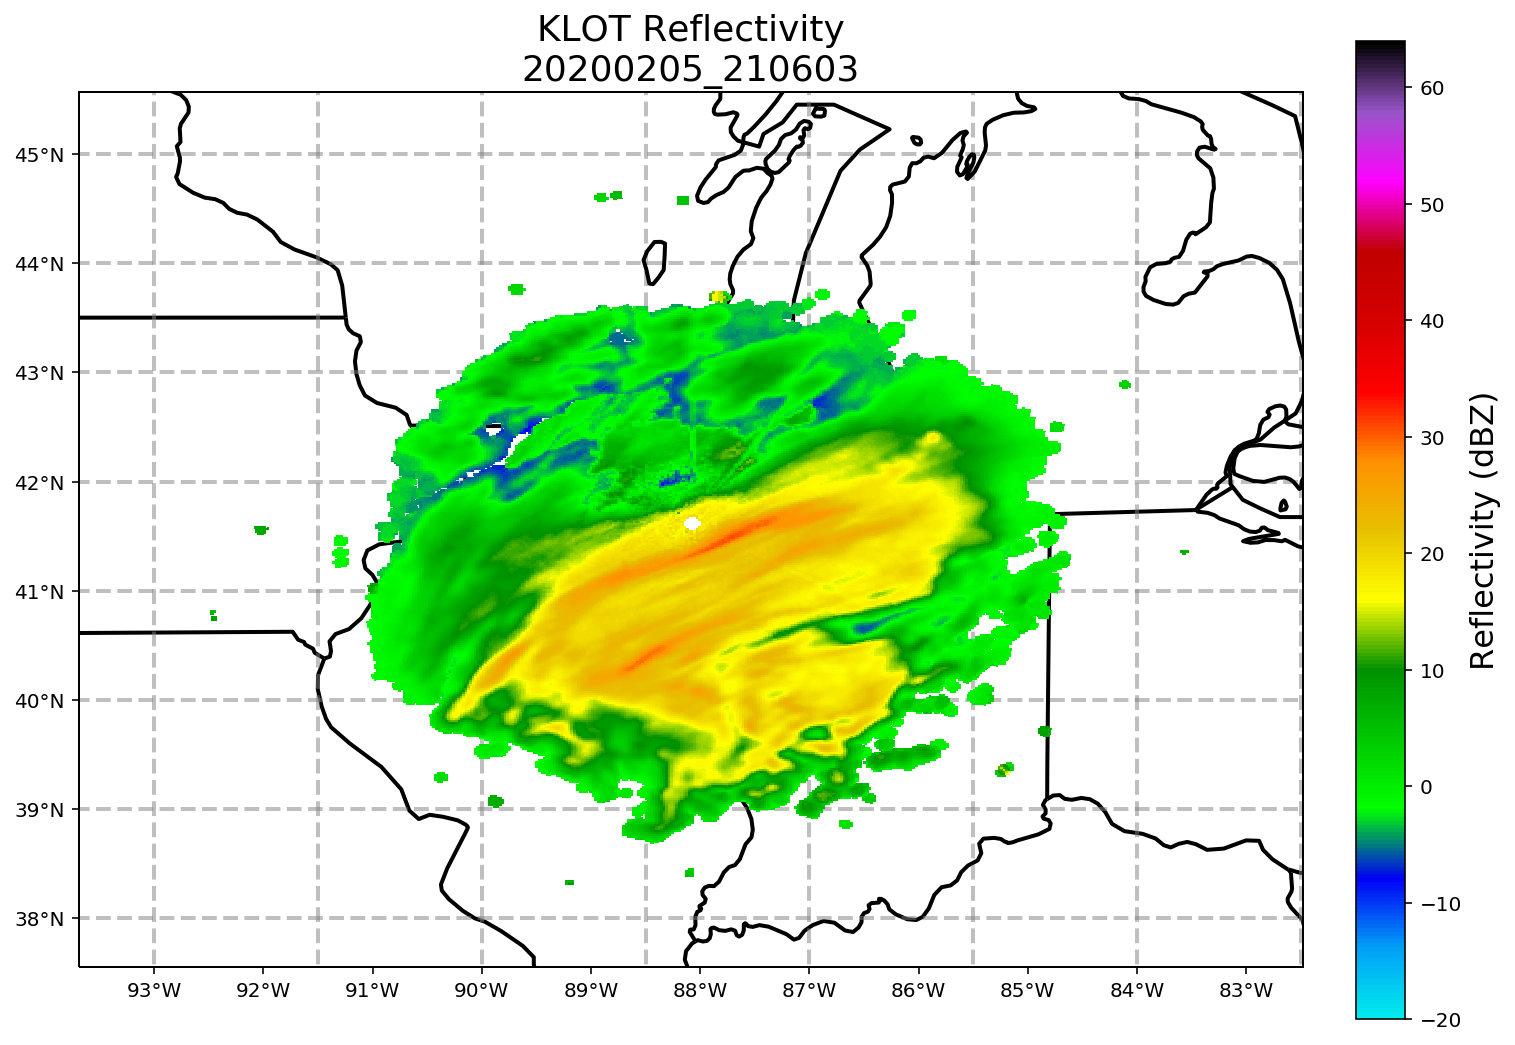

In [25]:
extent = [ds.lon.min(), ds.lon.max(), ds.lat.min(), ds.lat.max()]



#We are using Cartopy here which is the new mapping package in python. You can also use Basemap if you are not comfortable with Cartopy.
lat_lines = np.arange(np.around(ds.lat.min(), decimals=0), ds.lat.max(), 1)
lon_lines = np.arange(np.around(ds.lon.min(),decimals=0), ds.lon.max(), 1)
%config InlineBackend.figure_format='retina'
fig = plt.figure(figsize=[12, 9])
ax = plt.subplot(projection = ccrs.PlateCarree())

z_var = ds.reflectivity[0].sel(z=1000, method='nearest')
pc = z_var.plot.pcolormesh(transform=ccrs.PlateCarree(), ax=ax, x='lon', y='lat', vmin=-20, vmax=64, cmap=pyart.graph.cm.NWSRef, add_colorbar=False, zorder = 10)

cb1 = plt.colorbar(mappable=pc, orientation='vertical', fraction=0.046, pad=0.04)
cb1.set_label('Reflectivity (dBZ)',fontsize=16)

ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_title(radar_id + ' Reflectivity' + '\n' + file_name_sample[-19:-4],fontsize=18)
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
gl = ax.gridlines(draw_labels=False, linewidth=2, color='gray', alpha=0.5, linestyle='--')

political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',name='admin_0_boundary_lines_land', scale='50m', facecolor='none')
states = cartopy.feature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines', scale='50m', facecolor='white')
coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='50m', facecolor='none', name='blue')

ax.add_feature(cfeature.LAKES.with_scale('50m'), zorder = 9, edgecolor='black', facecolor = 'none', linewidth=2)
ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), zorder = 9, edgecolor='black', facecolor = 'none', linewidth=2)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), zorder = 9, edgecolor='black', facecolor = 'none', linewidth=2)

#ax.set_extent(extent)

plt.show()